# Stat 220 Final Examination – Take Home


You will work with three separate datasets (your instructor will provide actual files or simulation code):



In [177]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.utils import resample

import statsmodels.api as sm
import statsmodels.formula.api as smf

!pip install bambi
import bambi as bmb
import arviz as az

## Part 1. Home Energy Use (Regression, Transformations, Trees)

You are given the dataset `energy.csv`, which contains information about houses and their monthly electricity usage.

The target variable is **`monthly_energy_kwh`**, and other variables may include:

- `house_size` (square feet, continuous)  
- `num_occupants` (integer)  
- `avg_outdoor_temp` (°F, continuous)  
- `num_appliances` (integer)  
- `insulation_quality` (categorical: `"low"`,  `"high"`)  
- `heating_type` (categorical: e.g., `"electric"`, `"gas"`, `"heat_pump"`)  

The dataset cn be found at "https://github.com/drbob-richardson/stat220/raw/main/data/energy.csv"



### Problem 1.

- Read in `energy.csv`.
- Plot a histogram of `monthly_energy_kwh`.
- Based on the plot, comment briefly on whether energy looks skewed enough that a log transformation might be useful.


In [178]:
cn = pd.read_csv("https://github.com/drbob-richardson/stat220/raw/main/data/energy.csv")

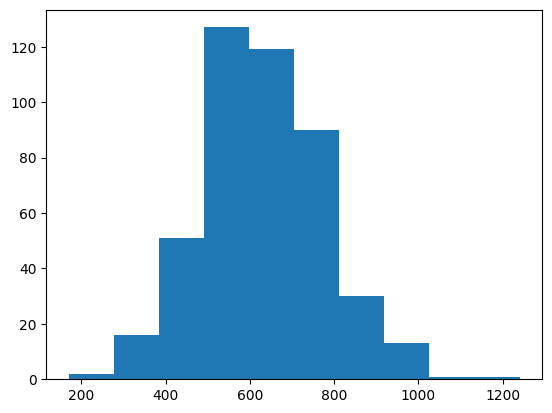

In [179]:
plt.hist(cn.monthly_energy_kwh)
plt.show()

No, I do not believe that the data needs a log transformarion based on the graph. There are no strong outliers and the distribution is pretty symmetrical and normal.

### Problem 2.

- Create dummy variables for categorical predictors (e.g., `insulation_quality`, `heating_type`), remembering to drop one category for each as a baseline.
- Regardless of what you decided in Problem 1, do not take a log transformation of the target variable


In [180]:
predictors = cn[["insulation_quality","heating_type"]]
X = pd.get_dummies(predictors,drop_first = True)
X

,insulation_quality_low,heating_type_gas,heating_type_heat_pump
0,True,False,True
1,True,True,False
2,False,False,True
3,False,False,False
4,True,False,True
...,...,...,...
445,False,False,True
446,False,False,True
447,True,False,False
448,True,False,False


### Problem 3.

- Split the data into a training and test set.
- Fit a linear regression model to the training set
- Report the MSE for the train set and the test set

In [181]:
predictors = cn[["house_size","num_occupants","avg_outdoor_temp","num_appliances","insulation_quality","heating_type"]]
X = pd.get_dummies(predictors,drop_first = True)
y = cn.monthly_energy_kwh

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [182]:
reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train,y_train)

print('intercept:', mod_reg.intercept_)
dict(zip(X.columns,mod_reg.coef_))

intercept: 411.96554806321035


{'house_size': np.float64(0.17076597476901698),
 'num_occupants': np.float64(18.946936687163145),
 'avg_outdoor_temp': np.float64(-3.6236704131743895),
 'num_appliances': np.float64(2.467540992187912),
 'insulation_quality_low': np.float64(46.56331538472753),
 'heating_type_gas': np.float64(-48.99045115203292),
 'heating_type_heat_pump': np.float64(-82.4919724363426)}

In [183]:
y_pred = mod_reg.predict(X_train)
rmse_reg_in = np.sqrt(mean_squared_error(y_train,y_pred))

out_sample_reg = mod_reg.predict(X_test)

rmse_reg_out = np.sqrt(mean_squared_error(y_test,out_sample_reg))

print(f'Train: {rmse_reg_in}')
print(f'Test: {rmse_reg_out}')


Train: 117.1235507802441
Test: 109.39153056297734


### Problem 4

- Create a plot of the fitted values against the residuals
- Based on this plot, does the target variable require a log transformation?



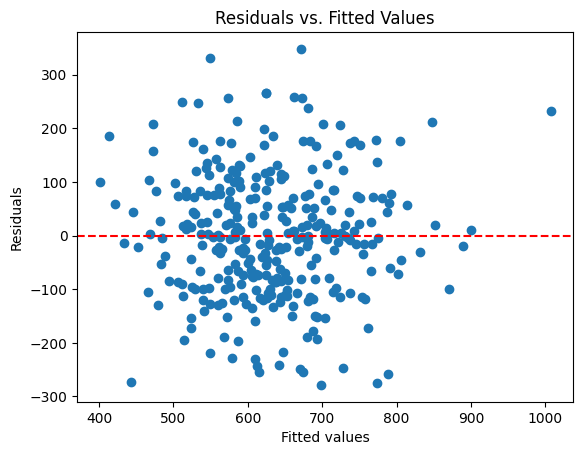

In [184]:
residuals = y_train - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r",linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

I would say no. The plot is centered around zero, has no strong patterns, and has a good spread across the graph.

### Problem 5

- Report the coefficient associated with average outdoor temperature in context along with the confidence interval


In [185]:
mod_cn = smf.ols("monthly_energy_kwh ~ house_size + num_occupants + avg_outdoor_temp + num_appliances + insulation_quality + heating_type", data=cn).fit()
mod_cn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     monthly_energy_kwh   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     38.73
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           2.52e-42
Time:                        00:01:11   Log-Likelihood:                -2772.2
No. Observations:                 450   AIC:                             5560.
Df Residuals:                     442   BIC:                             5593.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   360.7848     57.207      6.307      0.000     248.353     473.217
insulation_quality[T.low]    41.8786     12.561      3.334      0.001      17.192      66.566
heating_type[T.gas]         -48.9289     13.028     -3.756      0.000     -74.534     -23.324
heating_type[T.heat_pump]   -82.1780     14.372     -5.718      0.000    -110.425     -53.931
house_size                    0.1723      0.023      7.643      0.000       0.128       0.217
num_occupants                18.8887      3.800      4.971      0.000      11.421      26.356
avg_outdoor_temp             -3.2427      0.382     -8.497      0.000      -3.993      -2.493
num_appliances                3.6023      2.901      1.242      0.215      -2.098       9.303
==============================================================================
Omnibus:                        1.394   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.498   Jarque-Bera (JB):                1.455
Skew:                           0.131   Prob(JB):                        0.483
Kurtosis:                       2.908   Cond. No.                     2.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For an increase in one unit of average outdoor temperature, the monthly energy is expected to decrease by 3.2427 holding all else constant. We are 95% confident that the true value lies between -3.993 and -2.493.

### Problem 6

- Report the coefficient or coefficients associated with heating type in context along with the confidence interval(s)

When the heating type is gas, the monthly energy is expected to 48.9289 less than the electic heating type holding all else constant. We are 95% confident that the true value is between -74.534 and -23.324. When the heating type is heat pump, the monthly energy is expected to be 82.1780 less than the electic monthly energy holding all else constant. We are 95% confident that the true value is lies between -110.425 and -53.931.

### Problem 7

- Look at the p-values and identify any predictors with p-values above 0.05
- Iteratively remove one predictor at a time, starting with the largest p-value, refit the model and report the test MSE each time.


In [186]:
cn_train, cn_test = train_test_split(cn, test_size=0.3, random_state=4321)
mod_cn1 = smf.ols("monthly_energy_kwh ~ house_size + num_occupants + avg_outdoor_temp + num_appliances + insulation_quality + heating_type", data=cn_train).fit()
out_sample_preds = mod_cn1.predict(cn_test)
mse_all = mean_squared_error(cn_test.monthly_energy_kwh,out_sample_preds)
print(mod_cn1.summary())

                            OLS Regression Results                            
Dep. Variable:     monthly_energy_kwh   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     31.22
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.50e-32
Time:                        00:01:11   Log-Likelihood:                -1937.0
No. Observations:                 315   AIC:                             3890.
Df Residuals:                     307   BIC:                             3920.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [187]:
print(f'MSE: {mse_all}')

MSE: 14062.881581921769


In [188]:
mod_remove1 = smf.ols("monthly_energy_kwh ~ house_size + num_occupants + avg_outdoor_temp + insulation_quality + heating_type", data=cn_train).fit()
out_sample_preds2 = mod_remove1.predict(cn_test)
mse_remove1 = mean_squared_error(cn_test.monthly_energy_kwh,out_sample_preds2)
print(mod_remove1.summary())

                            OLS Regression Results                            
Dep. Variable:     monthly_energy_kwh   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     36.02
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           5.85e-33
Time:                        00:01:11   Log-Likelihood:                -1938.0
No. Observations:                 315   AIC:                             3890.
Df Residuals:                     308   BIC:                             3916.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [189]:
print(f'MSE: {mse_remove1}')

MSE: 13999.264246671515


In [190]:
#for problem 11
predictors = cn[["house_size","num_occupants","avg_outdoor_temp","insulation_quality","heating_type"]]
X = pd.get_dummies(predictors,drop_first = True)
y = cn.monthly_energy_kwh

X_train_removed, X_test_removed, y_train_removed, y_test_removed = train_test_split(X, y, test_size=0.3, random_state=1234)
reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train_removed,y_train_removed)

out_sample_reg = mod_reg.predict(X_test_removed)

r2_reg_out = r2_score(y_test,out_sample_reg)
print(r2_reg_out)

0.36378324169938314


### Problem 8.

- Use the same data set with all the variables and fit a regression tree.
- Fit the regression tree with depth 2, depth 3, depth 4, and depth 5.


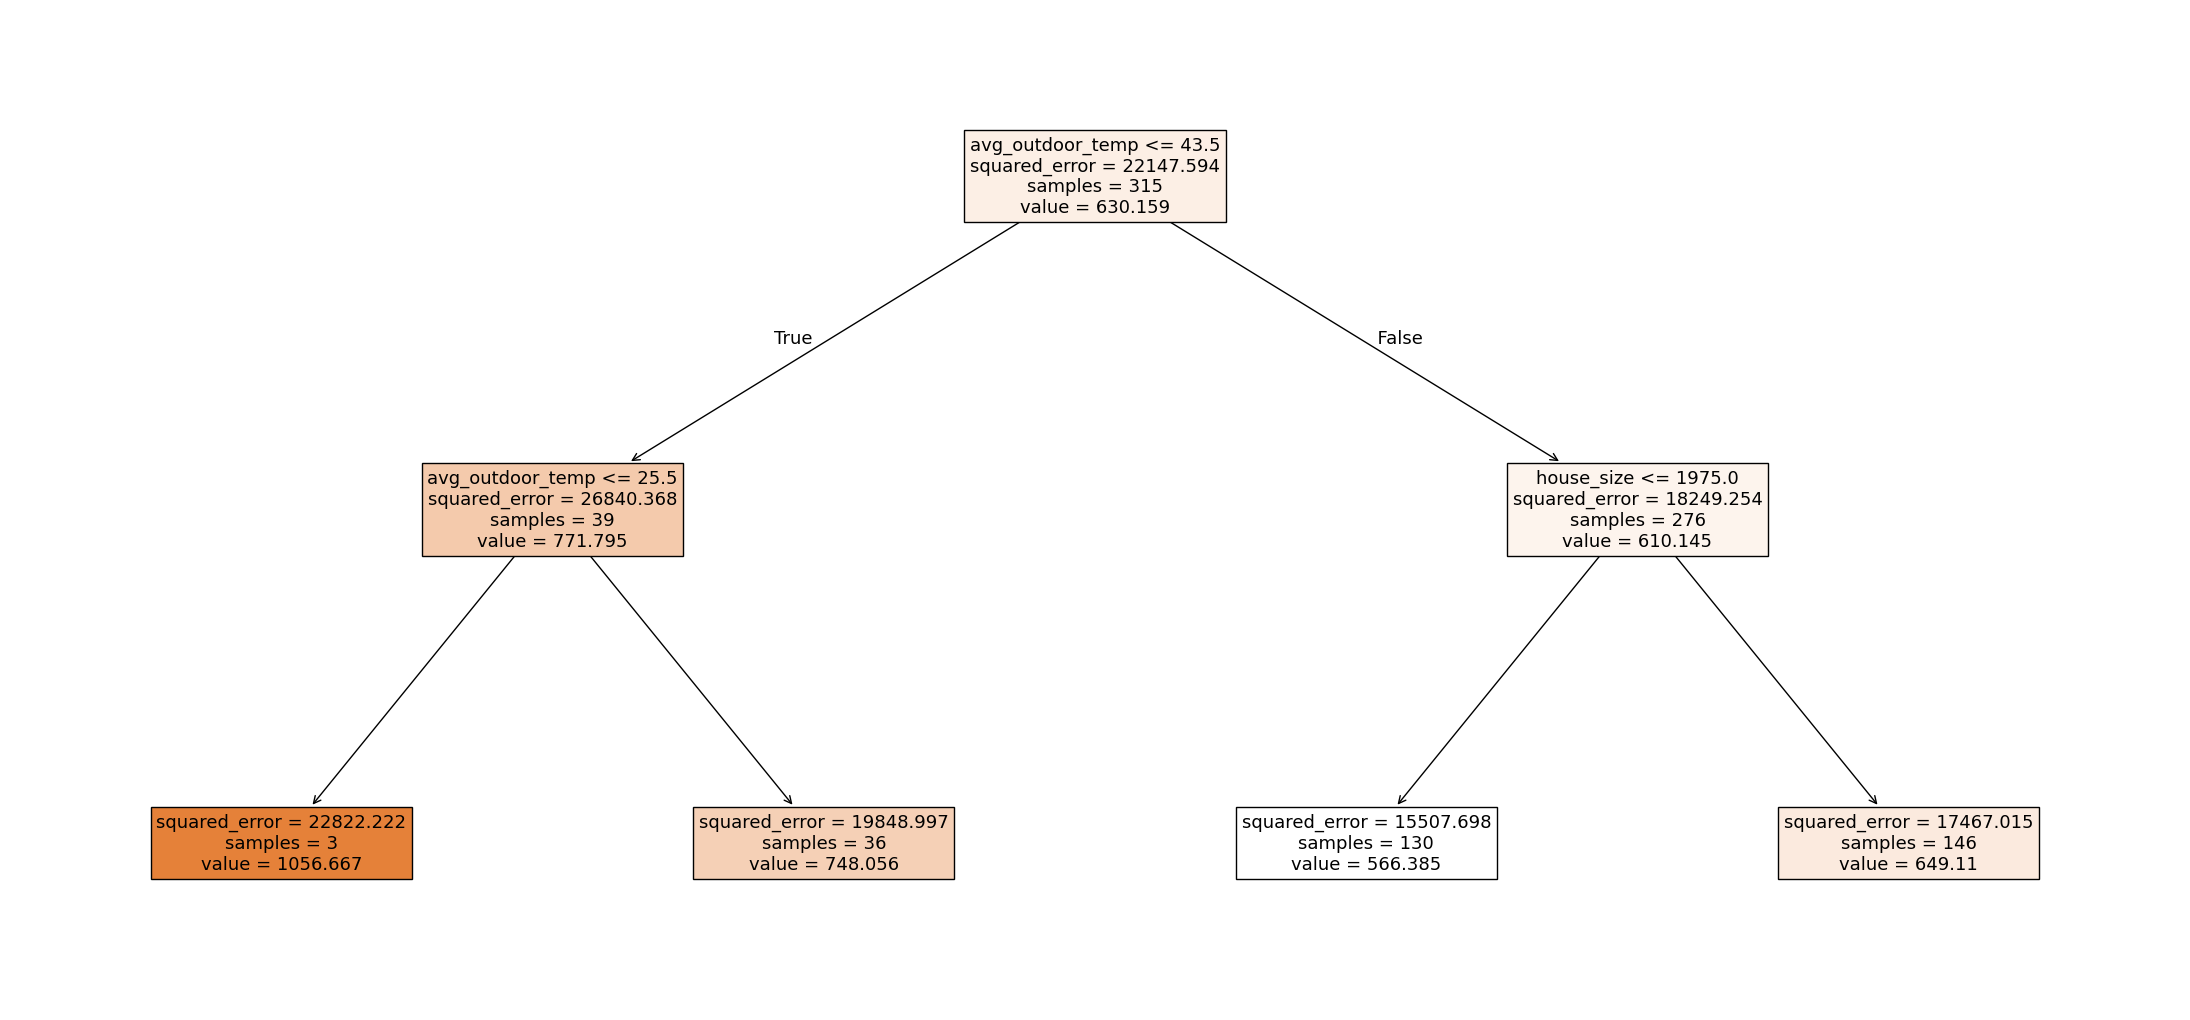

In [194]:
X_tree = pd.get_dummies(cn[["house_size","num_occupants","avg_outdoor_temp","num_appliances","insulation_quality","heating_type"]])
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.3, random_state=1234)

tree_prep2 = DecisionTreeRegressor(max_depth = 2)
mod_tree2 = tree_prep2.fit(X_train_tree,y_train)

plt.figure(figsize=(28, 13))
plot_tree(mod_tree2, feature_names=X_tree.columns, fontsize=13, filled=True)
plt.show()

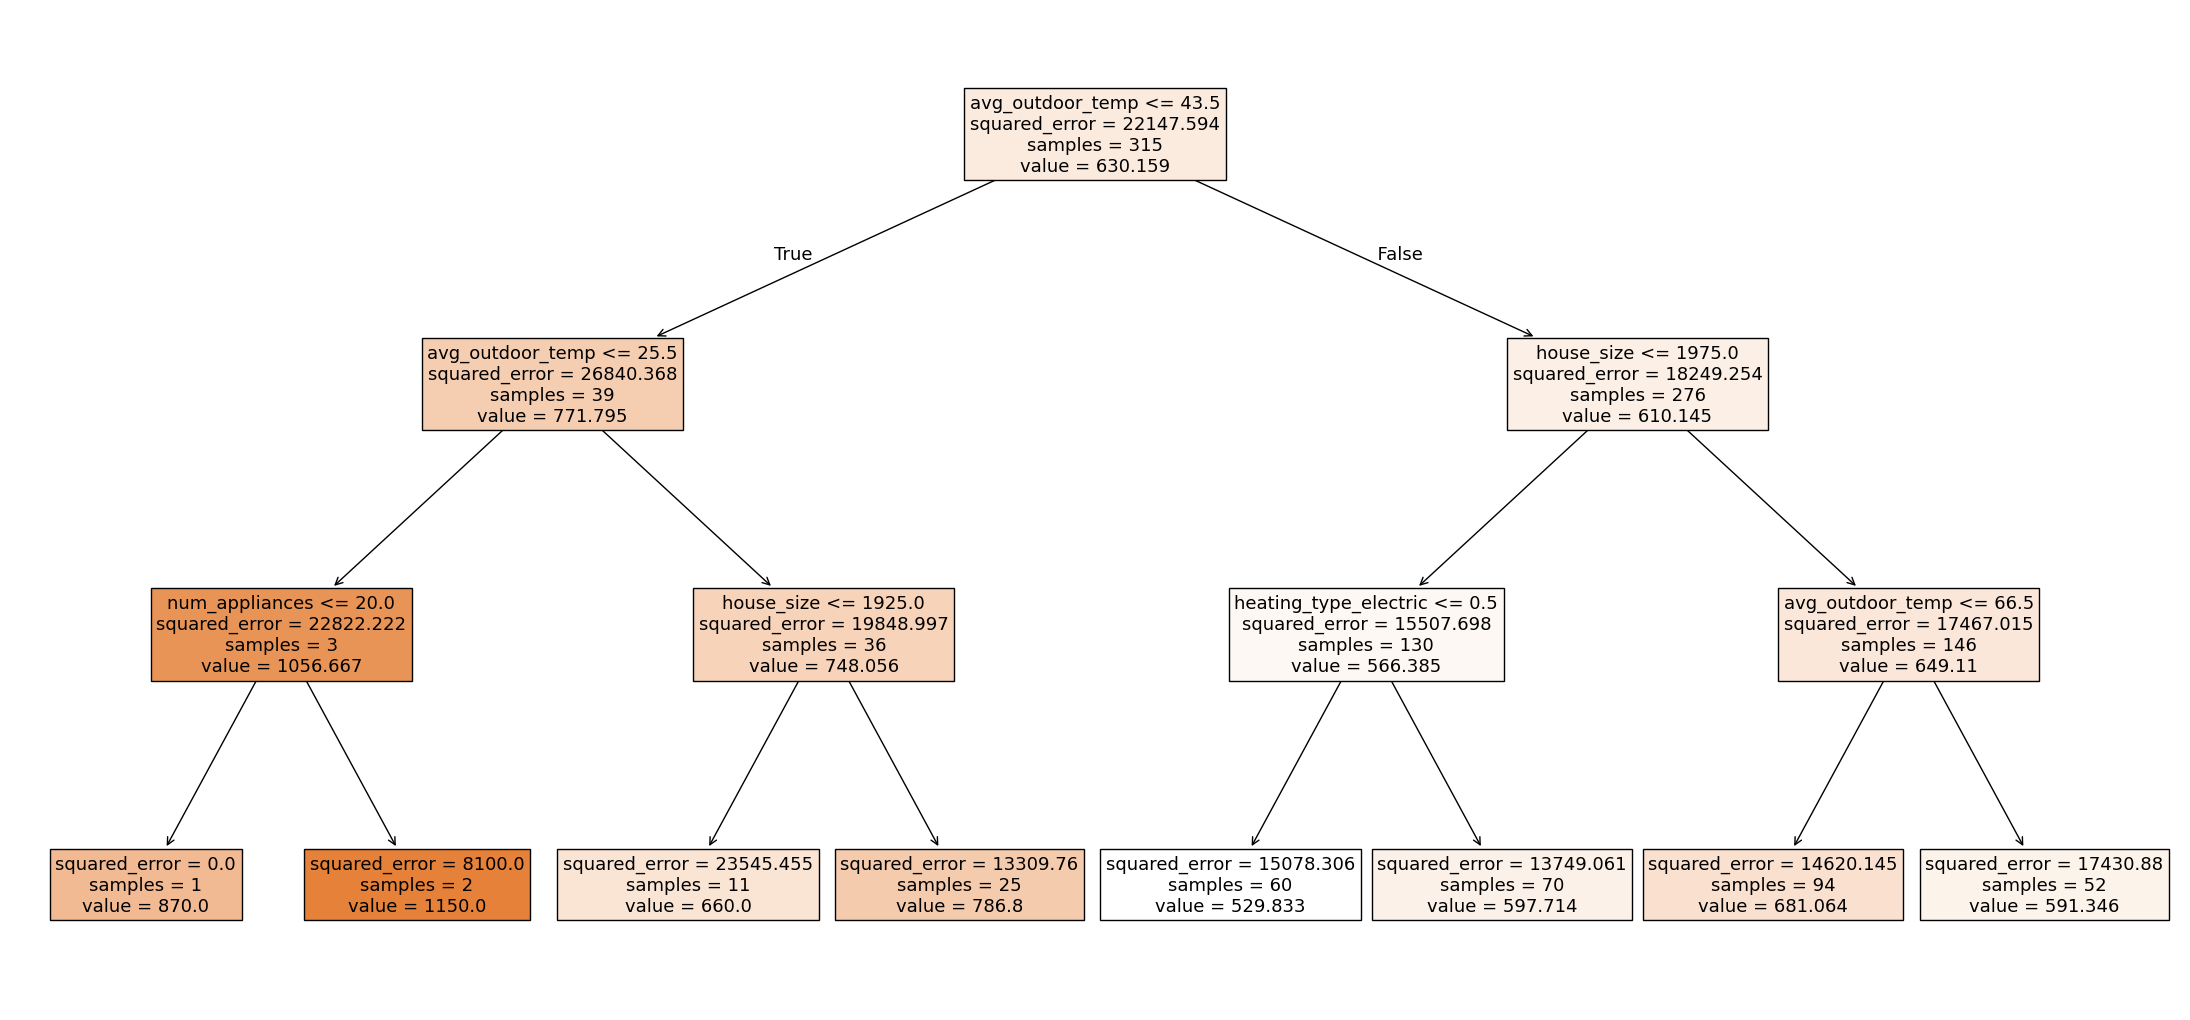

In [193]:
tree_prep3 = DecisionTreeRegressor(max_depth = 3)
mod_tree3 = tree_prep3.fit(X_train_tree,y_train)

plt.figure(figsize=(28, 13))
plot_tree(mod_tree3, feature_names=X_tree.columns, fontsize=13, filled=True)
plt.show()

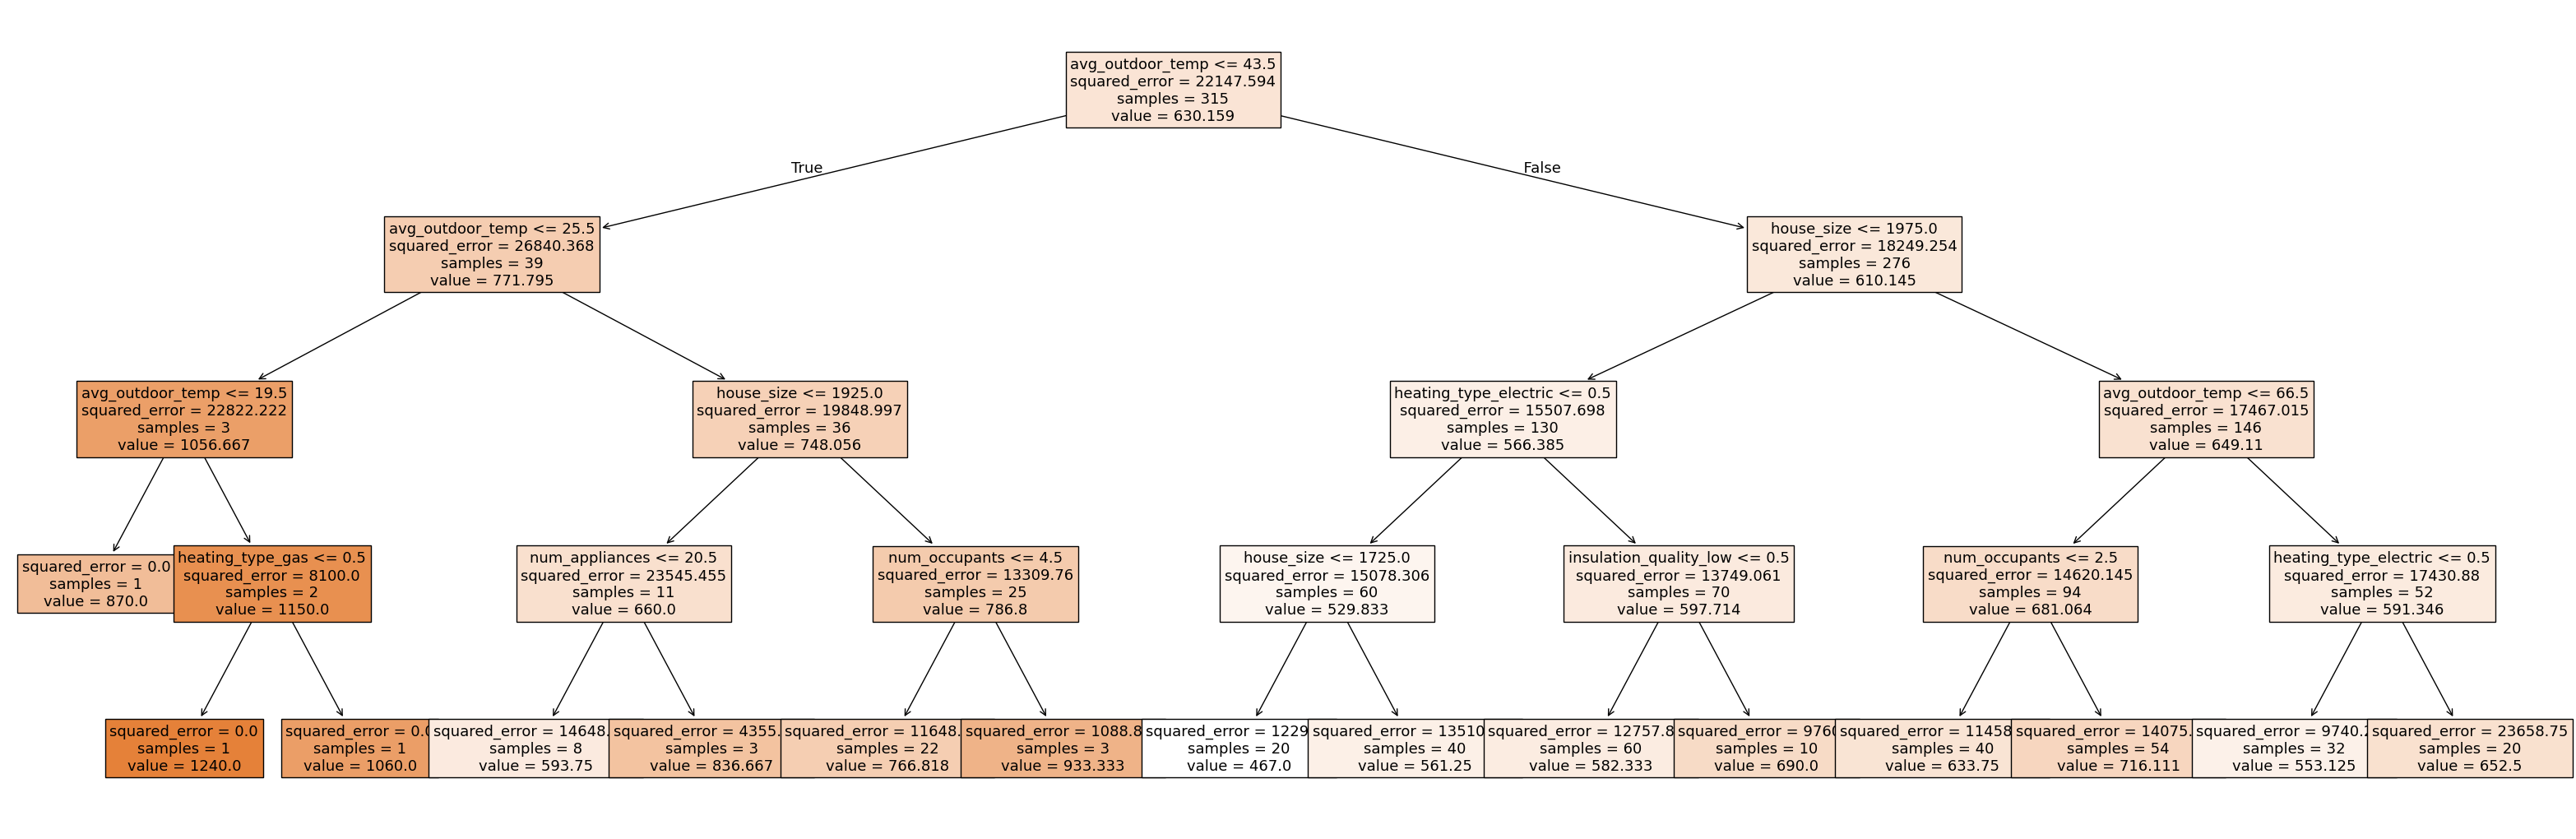

In [196]:
tree_prep4 = DecisionTreeRegressor(max_depth = 4)
mod_tree4 = tree_prep4.fit(X_train_tree,y_train)

plt.figure(figsize=(40, 13))
plot_tree(mod_tree4, feature_names=X_tree.columns, fontsize=13, filled=True)
plt.show()

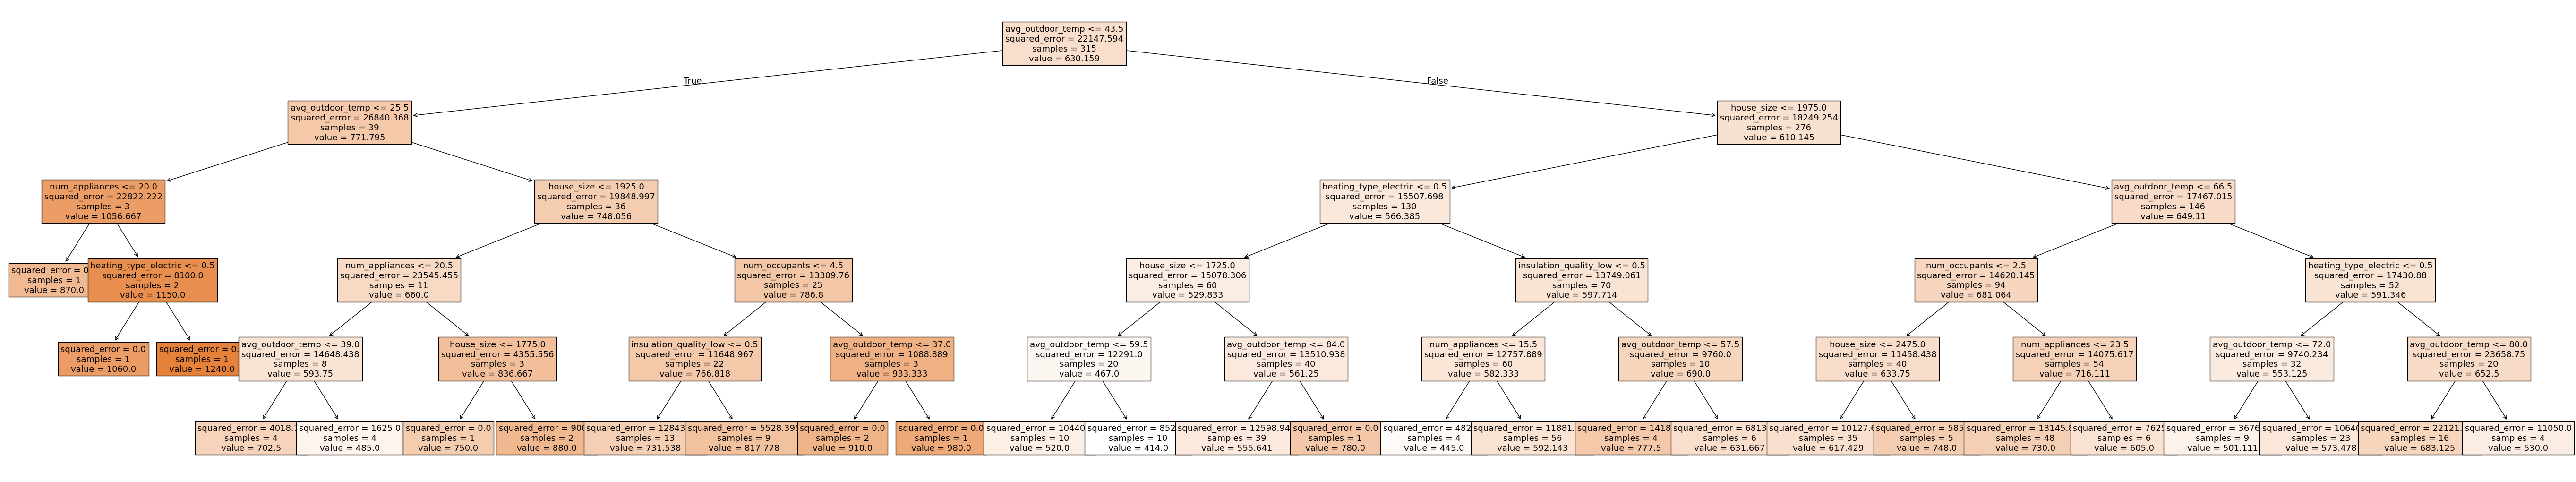

In [198]:
tree_prep5 = DecisionTreeRegressor(max_depth = 5)
mod_tree5 = tree_prep5.fit(X_train_tree,y_train)

plt.figure(figsize=(70, 13))
plot_tree(mod_tree5, feature_names=X_tree.columns, fontsize=13, filled=True)
plt.show()

### Problem 9

- Report the train and test set R^2 for all 4 models in Problem 8.
- Based on these metric which model is best?

In [199]:
in_sample_tree = mod_tree2.predict(X_train_tree)
r2_tree_in = r2_score(y_train,in_sample_tree)
print(f'r2 train depth 2: {r2_tree_in}')
out_sample_tree = mod_tree2.predict(X_test_tree)
r2_tree_out = r2_score(y_test,out_sample_tree)
print(f'r2 test depth 2: {r2_tree_out}')
print()

in_sample_tree3 = mod_tree3.predict(X_train_tree)
r2_tree_in3 = r2_score(y_train,in_sample_tree3)
print(f'r2 train depth 3: {r2_tree_in3}')
out_sample_tree3 = mod_tree3.predict(X_test_tree)
r2_tree_out3 = r2_score(y_test,out_sample_tree3)
print(f'r2 test depth 3: {r2_tree_out3}')
print()

in_sample_tree4 = mod_tree4.predict(X_train_tree)
r2_tree_in4 = r2_score(y_train,in_sample_tree4)
print(f'r2 train depth 4: {r2_tree_in4}')
out_sample_tree4 = mod_tree4.predict(X_test_tree)
r2_tree_out4 = r2_score(y_test,out_sample_tree4)
print(f'r2 test depth 4: {r2_tree_out4}')
print()

in_sample_tree5 = mod_tree5.predict(X_train_tree)
r2_tree_in5 = r2_score(y_train,in_sample_tree5)
print(f'r2 train depth 5: {r2_tree_in5}')
out_sample_tree5 = mod_tree5.predict(X_test_tree)
r2_tree_out5 = r2_score(y_test,out_sample_tree5)
print(f'r2 test depth 5: {r2_tree_out5}')

r2 train depth 2: 0.23325139300966513
r2 test depth 2: 0.11986982539075253

r2 train depth 3: 0.31831413810579556
r2 test depth 3: 0.10593178290444427

r2 train depth 4: 0.4205666349308719
r2 test depth 4: 0.11951770061782774

r2 train depth 5: 0.514117858981536
r2 test depth 5: -0.022859620797171853


The best model would be depth 2. While the training set gets better for each further depth for in sample r2, the test is best in the model with only a depth of 2.

### Problem 10

- Add 4 interactions to the final linear regression model from Problem 7
  - `avg_outdoor_temp^2`
  - `house_size^2`
  - `num_occupants * house_size` (interaction)
  - `avg_outdoor_temp * insulation_quality` (interaction with a dummy)
- Refit the model and keep any interactions that are significant.
- Remove the ones that are not significant and refit.

In [200]:
X = pd.get_dummies(cn[["house_size","num_occupants","avg_outdoor_temp","insulation_quality","heating_type"]], drop_first=True)

X["avg_outdoor_temp2"] = X["avg_outdoor_temp"]**2

y = cn.monthly_energy_kwh

X_train_higher, X_test_higher, y_train_higher, y_test_higher = train_test_split(X, y, test_size=0.3, random_state=4321)

X_train_sm = sm.add_constant(X_train_higher).astype(float)

model_higher_orders = sm.OLS(y_train_higher, X_train_sm).fit()
print(model_higher_orders.summary())


                            OLS Regression Results                            
Dep. Variable:     monthly_energy_kwh   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     32.32
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.70e-33
Time:                        00:05:42   Log-Likelihood:                -1934.7
No. Observations:                 315   AIC:                             3885.
Df Residuals:                     307   BIC:                             3915.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    588

In [201]:
#for problem 11
reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train_higher,y_train_higher)

out_sample_reg_higher = mod_reg.predict(X_test_higher)

r2_reg_out_higher = r2_score(y_test_higher,out_sample_reg_higher)
print(r2_reg_out_higher)

0.26601376590445114


### Problem 11

You have 3 final models,
- The final regression model from Problem 7
- The best regression tree model from Problem 9
- The final model from Problem 10
Use a justifiable method to determine which model is the best model out of those three.

In [202]:
print(f'r2 test problem 7: {r2_reg_out}')
print(f'r2 test problem 9: {r2_tree_out}')
print(f'r2 test problem 10: {r2_reg_out_higher}')

r2 test problem 7: 0.36378324169938314
r2 test problem 9: 0.11986982539075253
r2 test problem 10: 0.26601376590445114


The best model would be the model from problem 7 as it has the highest out of sample r2.

### Problem 12. Prediction for a new house.

Suppose you are given a new dataset `energy_new.csv` containing one new house.

- Read in that file and apply the same preprocessing as your training data:
- Using your linear regression model from Problem 10, compute:
  - The predicted **mean** `monthly_energy_kwh` for this house.
  - A 95% confidence interval for the mean prediction.
  - A 95% prediction interval for a single new observation.

The data set can be found at "https://github.com/drbob-richardson/stat220/raw/main/data/energy_new.csv"

In [203]:
energy_new = pd.read_csv("https://github.com/drbob-richardson/stat220/raw/main/data/energy_new.csv")

X_new = energy_new[["house_size","num_occupants", "avg_outdoor_temp","insulation_low","heating_gas", "heating_heatpump"]]
X_new = pd.get_dummies(X_new, drop_first=True)

X_new["avg_outdoor_temp2"] = X_new["avg_outdoor_temp"]**2

y = cn.monthly_energy_kwh

for col in model_higher_orders.model.exog_names:
    if col not in X_new.columns:
        X_new[col] = 0
X_new = X_new[model_higher_orders.model.exog_names]

pred = model_higher_orders.get_prediction(X_new)

summary = pred.summary_frame(alpha=0.05)
print(summary[['mean','mean_ci_lower','mean_ci_upper','obs_ci_lower','obs_ci_upper']])

         mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  143.301515     -57.085319     343.688349   -157.445728    444.048758


### Problem 13

Use the best regression tree model from Problem 9. Find a 95% bootstrap confidence interval for the new home in `energy_new.csv`.

In [204]:
X_new_tree = energy_new[["house_size", "num_occupants", "avg_outdoor_temp", "num_appliances", "insulation_low", "heating_gas", "heating_heatpump"]]
X_new_tree = pd.get_dummies(X_new_tree, drop_first=True)

for col in X_tree.columns:
    if col not in X_new_tree.columns:
        X_new_tree[col] = 0
X_new_tree = X_new_tree[X_tree.columns]

bootstrap_models = []

n_bootstrap_samples = 1000

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X_train_tree, y_train)

    regressor = DecisionTreeRegressor(max_depth = 2)
    regressor.fit(X_sample, y_sample)

    bootstrap_models.append(regressor)


new_house_predictions = [model.predict(X_new_tree)[0] for model in bootstrap_models]

lower_bound_new_house = np.percentile(new_house_predictions, 2.5)
upper_bound_new_house = np.percentile(new_house_predictions, 97.5)

print(f"Prediction interval for the new student: Lower Bound = {lower_bound_new_house}, Upper Bound = {upper_bound_new_house}")

Prediction interval for the new student: Lower Bound = 578.8504266991771, Upper Bound = 816.1607142857143


### Problem 14.

- Start with the original data frame.
- Use only the variables for house size and insulation quality as predictors.
- Fit a Bayesian linear regression model to predict eergy usage using only those two variables.

Output()

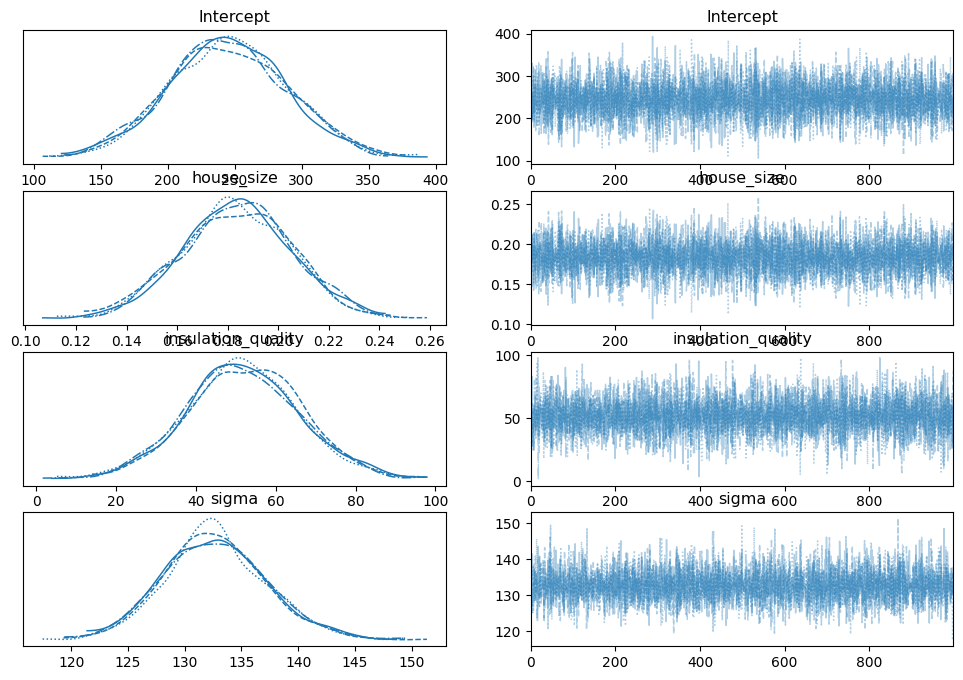

In [205]:
cn['insulation_quality'] = cn['insulation_quality'].astype("category")
model = bmb.Model("monthly_energy_kwh ~ house_size + insulation_quality",cn)

results = model.fit(draws=1000, chains=4)

az.plot_trace(results)
plt.show()

### Problem 15

Using the model fit in Problem 14, find the probability that the coefficient associated with higher quality insulation is positive.

In [206]:
posterior = results.posterior.stack(draws=("chain","draw"))
insulation_post = posterior["insulation_quality"].values

print((insulation_post > 0).mean())

1.0
